## Implicit feedbackを想定し、ポジションバイアスと過去の方策の影響を調査  
  
# 特徴量の説明
feature:  ユーザーのクリックを決める特徴量(5に近いとクリックしやすい)  
populality:  一ヶ月ごとの人気度を表す特徴量(5に近いと推薦されやすい。人気順の推薦を想定)  
また、train, testは7:3  

ポジションバイアスはE[O(u,i)]としpow_trueパラメータを0~0.9まで動かす  
C(u,i,k) = O(u,i)*R(u,i)  
E[C(u,i,k)] = THETA(u,i)*r(u,i)  

r(u,i)をfeatureとし、0-1スケールに変換。featureはあくまで特徴量なので、  
誤クリックを加えることで過学習を防ぐ

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from train import train
loader = train(
    train_policy="random",
    test_policy="random",
    train_pow_true=None,
    test_pow_true=None
)
map_5, profile = loader.ranking_train()
print(f'ユーザプロファイル: {round(profile,2)}')
print('-----------------------------------')
print(f'MAP@7: {round(map_5,2)}')

ユーザプロファイル: 3.65
-----------------------------------
MAP@7: 0.09


メモリベースにおいてバイアスの対処がわからない、、、  
モデルベースならクリックの期待値をポジションバイアスで割るように学習するのだが、

In [3]:
# パラメータごとの複数回施行平均値をとってみる

pow_true = [None,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
policys = ["random", "populality"]

plot_list = []

for train_policy in policys:
    for test_policy in policys:
        p_map = []
        for p in pow_true:
            sum_map = []
            user_profile = []
            for i in range(10):
                loader = train(
                    train_policy=train_policy,
                    test_policy=test_policy,
                    train_pow_true=p,
                    test_pow_true=p
                )
            
                map_7, profile = loader.ranking_train()
                sum_map.append(map_7)
        
            mean_map = np.mean(sum_map)
            p_map.append(mean_map)
            
        submit_dict = {"train_policy": train_policy, "test_policy": test_policy, "map_list": p_map}
        plot_list.append(submit_dict)
            

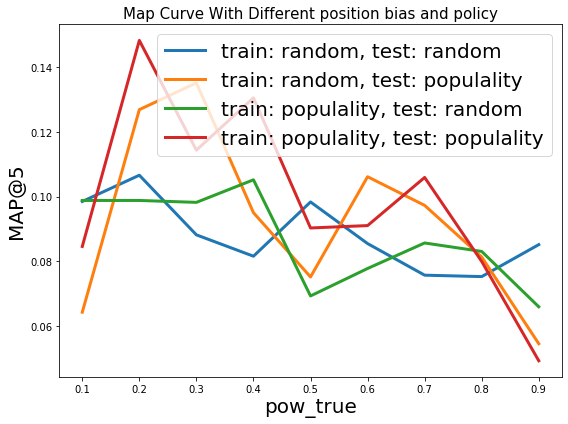

In [8]:
plt.subplots(1, figsize=(8,6))
plt.plot(pow_true, plot_list[0]["map_list"], label="train: random, test: random", linewidth=3)
plt.plot(pow_true, plot_list[1]["map_list"], label="train: random, test: populality", linewidth=3)
plt.plot(pow_true, plot_list[2]["map_list"], label="train: populality, test: random", linewidth=3)
plt.plot(pow_true, plot_list[3]["map_list"], label="train: populality, test: populality", linewidth=3)


plt.title("Map Curve With Different position bias and policy", fontdict=dict(size=15))
plt.xlabel("pow_true", fontdict=dict(size=20))
plt.ylabel("MAP@5", fontdict=dict(size=20))
plt.tight_layout()
plt.legend(loc="best", fontsize=20)
plt.show()
    

mapの値が下る傾向にあるが人口データからのシュミレートはムズいな、  
  
考察:  
・テストのポリシーがランダムだとアイテムがまんべんなくログに残るのでポジションバイアスの影響が少ないようにみえる  
・テストのポリシーが同じだとmapの値の遷移が似てくるようだ。これはポジションバイアスの影響というよりか、featureの値大きいものがサンプルされにくなっているのだろう。  
・pow_trueが0.2近辺のときに精度が高いのがナゾ（naiveに推定しているはずなので、ポジションバイアス対策をしていないから）

# 今後の課題  
### 1. 今回のようなメモリベースの推薦手法でポジションバイアスを考慮した推薦する  
### 2. オフ方策に基づいた推薦をする。